In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import csv
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from scipy.stats import t

def welch_ttest(x1, x2,alternative):
    n1 = x1.size
    n2 = x2.size
    m1 = np.mean(x1)
    m2 = np.mean(x2)
    v1 = np.var(x1, ddof=1)
    v2 = np.var(x2, ddof=1)
    tstat = (m1 - m2) / np.sqrt(v1 / n1 + v2 / n2)
    df = (v1 / n1 + v2 / n2)**2 / (v1**2 / (n1**2 * (n1 - 1)) + v2**2 / (n2**2 * (n2 - 1)))
    if alternative == "equal":
        p = 2 * t.cdf(-abs(tstat), df)
    if alternative == "lesser":
        p = t.cdf(tstat, df)
    if alternative == "greater":
        p = 1-t.cdf(tstat, df)
    return tstat, df, p

In [4]:
import json

def get_mutation_data(deleterious=False):
    cond_list = sorted(list(set(single_adata.obs['condition'])))
    cond_list.remove('NTC')

    data_dir = './data/cancer'

    mutation_dict = {}
    for cond in cond_list:
        if cond != 'NTC':
            file_name = '{}.cases.2021-02-12.json'.format(cond)
            with open(os.path.join(data_dir,file_name)) as f:
                data = json.load(f)

                for n in data:
                    if n['case_id'] not in mutation_dict:
                        mutation_dict[n['case_id']] = np.zeros(len(cond_list))
                    mutation_dict[n['case_id']][cond_list.index(cond)] = 1

    for cond in cond_list:
        if cond != 'NTC':
            file_name = '{}.LAML.cases.2021-02-13.json'.format(cond)
            if os.path.exists(os.path.join(os.path.join(data_dir,file_name))):
                with open(os.path.join(data_dir,file_name)) as f:
                    data = json.load(f)

                    for n in data:
                        if n['case_id'] not in mutation_dict:
                            mutation_dict[n['case_id']] = np.zeros(len(cond_list))
                        mutation_dict[n['case_id']][cond_list.index(cond)] = 1

    # add mutation data (zeros) for cases without BAF mutations
    for case_id in bulk_adata.obs['case_id'].values:
        if case_id not in mutation_dict:
            mutation_dict[case_id] = np.zeros(len(cond_list))

    mutation_df = pd.DataFrame(np.array([mutation_dict[n] for n in sorted(mutation_dict.keys())]))
    mutation_df.index = sorted(mutation_dict.keys())
    mutation_df.columns = cond_list

    return mutation_df

In [5]:
def get_barcode_mutation_data(bulk_adata,mutations='all'):
    
    data_dir = './data/cancer/maf_files'

    barcode_mutation_dict = {}

    for project_id in list(set(bulk_adata.obs['project_id'])):
        print(project_id)
        subdir = 'gdac.broadinstitute.org_{}.Mutation_Packager_Calls.Level_3.2016012800.0.0'.format(project_id.split('-')[1])

        for barcode in bulk_adata[bulk_adata.obs['project_id'] == project_id].obs['barcode'].values:
            barcode = barcode[:-1]
            path = os.path.join(data_dir,subdir,'{}.maf.txt'.format(barcode))
            if os.path.exists(path):        
                df = pd.read_csv(path,sep='\t',encoding = "ISO-8859-1")
                
                if mutations != 'all':
                    
                    if mutations == 'strong':
                        mutations2keep = ['Nonsense_Mutation','Frame_Shift_Del','Frame_Shift_Ins']
                        df = df.iloc[[i for i,n in enumerate(df['Variant_Classification'].values) 
                                      if n in mutations2keep]]
                        
                    if mutations == 'frame_shift':
                        mutations2keep = ['Frame_Shift_Del','Frame_Shift_Ins']
                        df = df.iloc[[i for i,n in enumerate(df['Variant_Classification'].values) 
                                      if n in mutations2keep]]
                        
                    elif mutations == 'non_silent':
                        # remove silent mutations!
                        df = df[df['Variant_Classification'] != 'Silent']
                        df = df[df['Variant_Classification'] != 'RNA']

                barcode_mutation_dict[barcode] = df['Hugo_Symbol'].values
    
    return barcode_mutation_dict

## Single-Cell Data

In [6]:
data_dir = './baf/data'

single_adata = sc.read(os.path.join(data_dir,'single.filtered.updated.h5ad'))

X = single_adata.raw.X.toarray() # already log-transformed

# z-score
ntc_inds = np.where(single_adata.obs['condition'] == 'NTC')[0]
ntc_mean = X[ntc_inds].mean(0)
ntc_std = X[ntc_inds].std(0)
ntc_std[ntc_std == 0] = 1

X = (X-ntc_mean)/ntc_std

z_max = 20
print(z_max)
single_adata.X = np.clip(X,-z_max,z_max)

Only considering the two last: ['.updated', '.h5ad'].
Only considering the two last: ['.updated', '.h5ad'].
20


In [7]:
results_dir = './single_by_cond'

W = np.loadtxt(os.path.join(results_dir,'W_all_more.txt'),delimiter='\t')
H = np.loadtxt(os.path.join(results_dir,'H_all_more.txt'),delimiter='\t')

single_adata.varm['H_nmf_all'] = H.T

### NMF

In [8]:
from scipy.stats import spearmanr

N = 10
K = single_adata.varm['H_nmf_all'].shape[1]

top_genes = []
gene_list = np.array(single_adata.var.index.values)

nmf_genes = {}
nmf_gene_inds = {}
for i in range(K):
    inds = np.argsort(-single_adata.varm['H_nmf_all'][:,i])[0:N]
    genes = single_adata.var.index.values[inds]
    # remove mitochondrial + ribosomal genes
    genes = [g for g in genes if 'MRPL' != g[0:4] and 'MRPS' != g[0:4] and 'MT-' != g[0:3] \
               and 'RPL' != g[0:3] and 'RPS' != g[0:3]]

    nmf_genes[i] = np.array(genes)
    nmf_gene_inds[i] = inds 

nmf_inds2use = list(range(K))
print(len(nmf_inds2use))

282


In [9]:
# calculate BAF program scores here
program_scores = []
for i in range(K):
    program_scores.append(single_adata.X[:,nmf_gene_inds[i]].mean(1))
program_scores = np.array(program_scores).T

### Load Classifiers

In [10]:
import pickle

z_max = 20
data_dir = './results/cancer/RFclassifier/classifiers/z20.softmax.n10.cv.rf200.bycond_more'.format(z_max)

classifiers_dict = {}
for cond in list(set(single_adata.obs['condition'])):
    with open(os.path.join(data_dir,'RF.{}.pkl'.format(cond)), 'rb') as f:
        classifiers_dict[cond] = pickle.load(f)

## TCGA Global

In [11]:
data_dir = './data/cancer/gdc_h5ad'
bulk_adata = sc.read(os.path.join(data_dir,'gdc_rnaseq.normalized.counts.h5ad'))
bulk_adata.X = np.clip(bulk_adata.X,-2,2)

# remove hypermutated tumors (380 - assuming we want < 10 mut/Mb and there 38 Mb of exons)
bulk_adata.obs['num_mutations'] = bulk_adata.obs['num_mutations'].fillna(0)
bulk_adata = bulk_adata[bulk_adata.obs['num_mutations'] < 380]

Only considering the two last: ['.counts', '.h5ad'].
Only considering the two last: ['.counts', '.h5ad'].


In [12]:
file_sample_dict = {}
data_dir = './data/cancer/tcga_metadata'
df = pd.read_csv(os.path.join(data_dir,'File_metadata_tcga_counts.txt'),sep='\t')
file_sample_dict = {file_name: sample_type for sample_type,file_name \
                         in df[['cases.0.samples.0.sample_type','file_name']].values}
file_barcode_dict = {file_name: barcode for barcode,file_name \
                         in df[['cases.0.samples.0.submitter_id','file_name']].values}

barcode_list = [file_barcode_dict[n] for n in bulk_adata.obs['file_name'].values]

bulk_adata.obs['barcode'] = barcode_list

Trying to set attribute `.obs` of view, copying.


### Mutation Data (TCGA Data Portal)

In [13]:
deleterious = False

mutation_df = get_mutation_data(deleterious=deleterious)

if deleterious:
    case_id2file = {case_id:file_name for case_id,file_name in bulk_adata.obs[['case_id','file_name']].values}
    del_mutation_df = get_mutation_data(deleterious=True)
    inds2keep = [i for i,n in enumerate(del_mutation_df.index.values) if n in set(bulk_adata.obs['case_id'].values)]
    del_mutation_df = del_mutation_df.iloc[inds2keep]

    del_mutation_df.index = [case_id2file[n] for n in del_mutation_df.index.values]
    del_mutation_dict = {}
    for i,vec in enumerate(del_mutation_df.values):
        del_mutation_dict[del_mutation_df.index.values[i]] = del_mutation_df.columns[np.where(vec)[0]]

## Calculate Programs

In [14]:
K = single_adata.varm['H_nmf_all'].shape[1]

def calculate_bulk_programs(bulk_adata,nmf_genes):
    
    bulk_X = bulk_adata.X #.toarray()
    bulk_gene_idx_dict = {g:i for i,g in enumerate(bulk_adata.var['gene_symbol'].values)}

    bulk_nmf_gene_inds = {}
    for i in range(len(nmf_genes)):
        bulk_nmf_gene_inds[i] = [bulk_gene_idx_dict[g] for g in nmf_genes[i] if g in bulk_gene_idx_dict]

    # calculate bulk program scores here
    bulk_nmf_programs = []
    for i in range(K):
        bulk_nmf_programs.append(bulk_X[:,bulk_nmf_gene_inds[i]].mean(1))
    bulk_nmf_programs = np.array(bulk_nmf_programs).T
    bulk_nmf_programs[np.isnan(bulk_nmf_programs)] = 0
    
    return bulk_nmf_programs

bulk_nmf_programs = calculate_bulk_programs(bulk_adata,nmf_genes)
bulk_adata.obsm['X_programs'] = bulk_nmf_programs

<ipython-input-14-28a67d9f2756>:15: RuntimeWarning: Mean of empty slice.
  bulk_nmf_programs.append(bulk_X[:,bulk_nmf_gene_inds[i]].mean(1))
/data/cb/alexwu/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


### Calculate Tumor-BAF KO Similarity

In [15]:
from sklearn.preprocessing import normalize
from scipy.special import softmax

cond_list = sorted(list(set(single_adata.obs['condition'])))

corr_mat = np.zeros((bulk_nmf_programs.shape[0],len(cond_list)))

bulk_X = bulk_nmf_programs[:,nmf_inds2use]
bulk_X = softmax(bulk_X,axis=1)

for j,cond in enumerate(cond_list):
#     rare_X = normalize(rare_bulk_nmf_programs[:,nmf_inds2use],norm='l1')
    corr_mat[:,j] = classifiers_dict[cond].predict_proba(bulk_X)[:,1]
    
corr_mat = corr_mat.T
print(corr_mat.max(),corr_mat.min())

corr_df = pd.DataFrame(corr_mat,index=sorted(list(set(single_adata.obs['condition']))))

0.665 0.005


### BAF Signatures

In [16]:
cat1 = ['SMARCB1','SMARCA4','ARID1A','SMARCE1']
cat2 = ['ARID2','BRD7','PBRM1']
cat3 = ['BRD9','SMARCD1'] #,'GLTSCR1']
cat4 = ['ACTL6A']

cat_list = [cat1,cat2,cat3,cat4]
cat_names = ['cBAF/core','PBAF','ncBAF','ACTL6A']

In [17]:
from collections import Counter

filtered_mutation_df = mutation_df.copy().loc[list(bulk_adata.obs['case_id'])]

cond_list = sorted(list(set(single_adata.obs['condition'])))

#### cBAF

In [19]:
cat1 = ['SMARCB1','SMARCA4','ARID1A','SMARCE1']
cat2 = ['ARID2','BRD7','PBRM1']
cat3 = ['BRD9','SMARCD1','GLTSCR1']
cat4 = ['ACTL6A']

cat_list = [cat1,cat2,cat3,cat4]
cat_names = ['cBAF/core','PBAF','ncBAF','ACTL6A']

In [ ]:
cbaf_mut_case_inds = np.where(filtered_mutation_df[cat1].values.sum(1))[0]
no_cbaf_mut_case_inds = np.where(filtered_mutation_df.values.sum(1) == 0)[0]

*Similarity Score*

In [21]:
cbaf_mut_cossim = corr_df.iloc[:,cbaf_mut_case_inds].loc[cat1].values.mean(0)
no_cbaf_mut_cossim = corr_df.iloc[:,no_cbaf_mut_case_inds].loc[cat1].values.mean(0)

plot_df = pd.DataFrame({'mutations': ['cBAF-specific \nmutation(s)']*len(cbaf_mut_cossim) 
                        + ['no BAF \nmutation(s)']*len(no_cbaf_mut_cossim),
                       'cossim': cbaf_mut_cossim.tolist() + no_cbaf_mut_cossim.tolist()})

In [ ]:
from sklearn.metrics import roc_auc_score,average_precision_score,precision_recall_curve

y_true = (plot_df['mutations'] == 'cBAF-specific \nmutation(s)').astype(int)
y_score = plot_df['cossim'].values

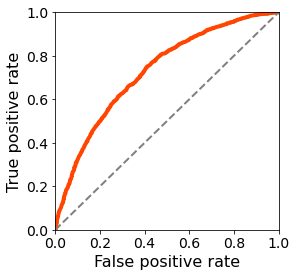

In [140]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_score)

plt.figure(figsize=(4,4))
plt.plot(fpr,tpr,lw=4,c='orangered')
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),lw=2,c='grey',linestyle='--')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('False positive rate',fontsize=16)
plt.ylabel('True positive rate',fontsize=16)
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

## BAF KO Similarity as Discovery Tool

### Tumors Similar to BAF KO Conditions (by Complex)

In [23]:
cat1 = ['SMARCA4','ARID1A','SMARCB1','SMARCE1']
cat2 = ['ARID2','BRD7','PBRM1']

cat3 = ['BRD9','SMARCD1']
cat4 = ['ACTL6A']

cat_list = [cat1,cat2,cat3,cat4]
cat_names = ['cBAF/core','PBAF','ncBAF','ACTL6A']

In [24]:
function_df = pd.read_csv('./general/GO_function_experimental_evidence_uniprot.txt',
                          sep='\t',header=None)

gene_function_dict = {}
for g,function in function_df[[1,4]].values:
    if g not in gene_function_dict:
        gene_function_dict[g] = []
    gene_function_dict[g].append(function)
gene_function_dict = {g: list(set(f)) for g,f in gene_function_dict.items()}

In [25]:
data_dir = './data/human_tfs'

human_tfs = pd.read_csv(os.path.join(data_dir,'Homo_sapiens_TF.txt'),sep='\t')['Symbol'].values

In [26]:
data_dir = './data/cancer/maf_files/'

barcode_specific_mutation_dict = {}

# variant_types = []
for project_id in list(set(bulk_adata.obs['project_id'])): #,'TCGA-KIRC','TCGA-COAD','TCGA-LIHC','TCGA-LUAD']:
    print(project_id)
    subdir = 'gdac.broadinstitute.org_{}.Mutation_Packager_Calls.Level_3.2016012800.0.0'.format(project_id.split('-')[1])

    for barcode in bulk_adata[bulk_adata.obs['project_id'] == project_id].obs['barcode'].values:
        barcode = barcode[:-1]
        path = os.path.join(data_dir,subdir,'{}.maf.txt'.format(barcode))
        if os.path.exists(path):        
            df = pd.read_csv(path,sep='\t')
#             df = df[df['Variant_Classification'] != 'Silent']
#             df = df[df['Variant_Classification'] != 'RNA']
            barcode_specific_mutation_dict[barcode] = [(g,t) for g,t 
                                                       in df[['Hugo_Symbol','Variant_Classification']].values]


TCGA-LUSC
TCGA-UCEC
TCGA-READ
TCGA-HNSC
TCGA-PRAD
TCGA-KIRC
TCGA-KICH
TCGA-COAD
TCGA-LIHC
TCGA-THCA
TCGA-ESCA
TCGA-STAD
TCGA-LUAD
TCGA-BLCA
TCGA-KIRP
TCGA-BRCA


In [27]:
from scipy.stats import hypergeom
from scipy.stats import fisher_exact

def calculate_enrichment(k,M,n,N):

    table = np.array([[k,N-k],[n,M-n]])
    p = fisher_exact(table,alternative='greater')[1]
    
    return p

def get_mutation_enrichment(mutation_counts,verbose=False):

    df_list = []
    for (project_id,num_samples) in mutation_counts:

        if num_samples >= 2:
            # get tumors without BAF mutations (from project_id)
            sample_bulk_adata = filtered_bulk_adata.copy()[filtered_bulk_adata.obs['project_id'] == project_id]
            inds2keep = np.where(mutation_df.loc[sample_bulk_adata.obs['case_id']].values.sum(1) == 0)[0]
            sample_bulk_adata = sample_bulk_adata[inds2keep]

            mutations_list = []
            for barcode in sample_bulk_adata.obs['barcode'].values:
                if barcode[:-1] in barcode_mutation_dict:
                    mutations_list.append(list(set(barcode_mutation_dict[barcode[:-1]])))

            # background
            bg_mutations_list = []
            for barcode in bulk_adata[bulk_adata.obs['project_id'] == project_id].obs['barcode'].values:
                if barcode[:-1] in barcode_mutation_dict:
                    bg_mutations_list.append(list(set(barcode_mutation_dict[barcode[:-1]])))

            N = len(mutations_list)
            M = len(bg_mutations_list)

            counts = Counter([g for gene_list in mutations_list for g in gene_list]) #.most_common()
            bg_counts = Counter([g for gene_list in bg_mutations_list for g in gene_list])

            gene_list = []
            p_list = []
            percent_list = []
            percent_bg_list = []
            count_list = []

            for g,c in counts.items():
                if c >= 2:
                    k = c
                    n = bg_counts[g]

                    p = calculate_enrichment(k,M,n,N)

                    p_list.append(p)
                    gene_list.append(g)

                    percent_list.append(k/N)
                    percent_bg_list.append(n/M) 
                    count_list.append(c)

            data_dict = {'gene': gene_list,'percent': percent_list,'counts': count_list,
                         'percent_bg': percent_bg_list, 'p': p_list}
            df = pd.DataFrame(data_dict)
            df['project_id'] = project_id

            df_list.append(df)

    df = pd.concat(df_list)
    
    return df


In [28]:
mutation_type = 'all'
barcode_mutation_dict = get_barcode_mutation_data(bulk_adata,mutations=mutation_type)

TCGA-LUSC
TCGA-UCEC
TCGA-READ
TCGA-HNSC
TCGA-PRAD
TCGA-KIRC
TCGA-KICH
TCGA-COAD
TCGA-LIHC
TCGA-THCA
TCGA-ESCA
TCGA-STAD
TCGA-LUAD
TCGA-BLCA
TCGA-KIRP
TCGA-BRCA


### cBAF/core

In [29]:
cbaf_scores = corr_df.loc[cat1].values.mean(0)
cbaf_thresh = np.percentile(cbaf_scores,90)

cbaf_mut_inds = set(np.where(mutation_df.loc[bulk_adata.obs['case_id'].values][cat1].values.sum(1))[0])
no_mut_inds = set(np.where(mutation_df.loc[bulk_adata.obs['case_id'].values].values.sum(1) == 0)[0])

case_inds = sorted(list(set(np.where(cbaf_scores > cbaf_thresh)[0]) & set(no_mut_inds)))

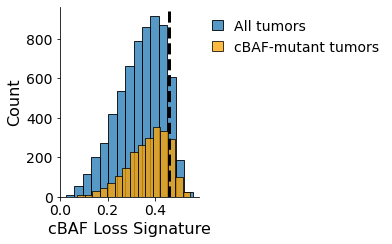

In [66]:
plt.figure(figsize=(2.5,3.5))
sns.histplot(cbaf_scores,bins=15,label='All tumors') #,ax=ax) #,norm_hist=False) #,bins=50)
sns.histplot(cbaf_scores[list(cbaf_mut_inds)],color='orange',bins=15,label='cBAF-mutant tumors') #,ax=ax) #,norm_hist=False) #,bins=50)

plt.axvline(x=cbaf_thresh,lw=3,color='black',linestyle='--')
plt.xlabel('cBAF Loss Signature',fontsize=16)
plt.ylabel('Count',fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine()
plt.legend(fontsize=14,bbox_to_anchor=(1,1),frameon=False,handlelength=0.8)
plt.show()

In [31]:
filtered_bulk_adata = bulk_adata[case_inds]
filtered_cases = filtered_bulk_adata.obs['case_id'].values

cbaf_counts = Counter(filtered_bulk_adata.obs['project_id']).most_common()

for n,count in cbaf_counts:
    print(n,count)
    

TCGA-COAD 20
TCGA-LUAD 14
TCGA-LUSC 11
TCGA-BRCA 9
TCGA-KIRP 5
TCGA-READ 4
TCGA-LIHC 2
TCGA-BLCA 2
TCGA-HNSC 1
TCGA-KIRC 1
TCGA-UCEC 1


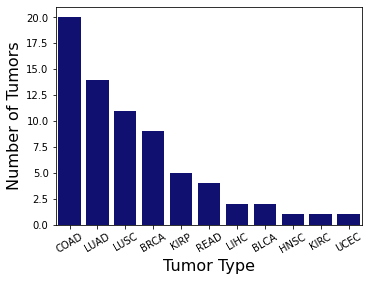

In [68]:
counts_df = pd.DataFrame(cbaf_counts)
counts_df.columns = ['class','n']
counts_df['class'] = [n.split('-')[1] for n in counts_df['class'].values]

plt.figure(figsize=(counts_df.shape[0]/2,4))
sns.barplot(x='class',y='n',data=counts_df,color='navy')
plt.xlabel('Tumor Type',fontsize=16)
plt.ylabel('Number of Tumors',fontsize=16)
plt.xticks(rotation=30)
plt.show()

#### By Project

In [32]:
df = get_mutation_enrichment(cbaf_counts)

In [33]:
from statsmodels.stats.multitest import fdrcorrection #multipletests

thresh = 0.1
all_genes = {}
all_sig_genes = []

all_group_df = []
for n,group_df in df.groupby('project_id'):
    reject,pvals_corrected = fdrcorrection(group_df['p'].values)
    group_df['q'] = pvals_corrected
    all_group_df.append(group_df)
    
    enriched_genes = group_df[group_df['q'] < thresh]['gene'].values
    all_sig_genes.extend(enriched_genes)
    for g,q in group_df[['gene','q']].values:
        if g in all_genes:
            if q < all_genes[g]:
                all_genes[g] = q
        else:
            all_genes[g] = q

all_group_df = pd.concat(all_group_df)

for g in all_genes.keys():
    print(g)

RAPGEF6
CDH1
TP53
EHMT1
MUC4
CHD2
KRAS
COL12A1
PIK3CA
ZFHX4
MUC16
FAT3
NAV3
COL4A5
APC
DLG2
PHLDB1
MUC17
DSEL
TTN
FBN1
TECTA
PLEKHA6
LAMA1
ACACB
PCOLCE2
PCDHB7
NALCN
KIF16B
RYR2
MYH2
ACRC
DNAH9
DNAH5
HOOK3
GPRC6A
CSMD3
USP51
ASB5
RXRG
KIAA2026
ASXL3
LRP1B
CYP8B1
KIF2B
AP1B1
ZNF804A
MAGEA4
CSMD1
OR4M1
NLRP12
PABPC5
FAT4
TNXB
LRFN5
CPS1
ODZ4
KIAA1797
IGSF22
NAV2
KCNH2
PCNT
Unknown
CCDC33
TNN
COL11A1
FOLH1
TRPC5
JPH2
COL9A1
MAPK8IP1
INADL
HCFC1
ASTN1
CLEC1A
USP26
CNGA4
OR2M7
ATXN3L
OR5L1
MOSPD2
GPHB5
CLCA4
SLC12A5
XRN1
PXDNL
NCAN
ZP2
ASTN2
SIGLEC11
PRDM9
ADAMTS16
DCAF4L2
ATRNL1
MTERFD1
KLHL4
PCDHA12
PGR
FAM154A
PDCD11
ANKRD30B
SNAI2
PSG8
PTPRD
C18orf34
EHMT2
NOX4
NBEA
HK1
ZNF718
MTMR10
EPHA5
USH2A
RBM10
DAB1
INTS2
SMYD4
MAGEC1
OBSCN
CRNN
FLNA
INSRR
DSC3
TLL1
CLEC16A
TEX13B
KCNA1
ATRX
PTGDR
FAM75C1
C9orf79
C9orf84
OR4N2
CDH12
KIAA1409
ANKRD30A
SRRT
DDI1
EIF2C2
SCN3A
XIRP2
CREBBP
KRT80
PLCB1
NFYC
CHL1
TRPS1
PLCL1
PCDH10
ZNF99
RNF17
DYNC1H1
CARD11
EMR2
SI
NTRK1
CCDC88A
HCN1
SLIT2
NTRK3
TRIM6

In [35]:
np.random.seed(1)

n_genes = 50

data_dict = {k: [] for k in ['gene','q']}
for g,q in all_genes.items():
    data_dict['gene'].append(g)
    data_dict['q'].append(q)
enrich_df = pd.DataFrame(data_dict)
enrich_df.index = enrich_df['gene'].values
enrich_df = enrich_df[enrich_df['q'] < 0.1]
enrich_df['-log10q'] = -np.log10(enrich_df['q'])
enrich_df = enrich_df.sort_values('q')

# add functions
terms2keep = ['transcription factor','kinase activity','phosphatase activity',
              'GTPase binding','GTPase activity','RNA binding','protein binding','methyltransferase']

function_list = []
for i,g in enumerate(enrich_df['gene'].values):
    gene_function_list = []
    if g in gene_function_dict:
#         print(g,gene_function_dict[g])
        for j,function_term in enumerate(terms2keep):
            for gene_function in gene_function_dict[g]:
                if function_term in gene_function:
                    gene_function_list.append(function_term)
    if g in human_tfs:
        gene_function_list.append('transcription factor')
    gene_function = ';'.join(sorted(list(set(gene_function_list))))
    function_list.append(gene_function)
enrich_df['annotated_functions'] = function_list

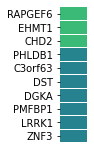

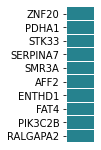

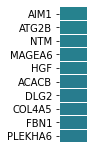

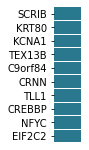

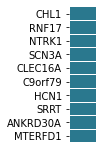

In [34]:
for i in range(0,n_genes,10):
    fg = plt.figure(figsize=(0.5,10/4)) 
    sns.heatmap(enrich_df[['-log10q']].iloc[i:i+10],vmin=0,vmax=3,
                xticklabels=False,cmap='viridis',cbar=False,linewidth=0.005) #,cbar_kws={'shrink': 2})
    plt.show()

In [38]:
mutation_types = sorted(list(set([v[1] for mut_list in barcode_specific_mutation_dict.values() 
                                  for v in mut_list])))

sorted_genes = sorted(list(set(enrich_df['gene'].values)))
mut_freq_df = pd.DataFrame(np.zeros((len(sorted_genes),len(mutation_types))),
                           index=sorted_genes,columns=mutation_types)

filtered_barcode_set = set([n[:-1] for n in filtered_bulk_adata.obs['barcode'].values])
for barcode,mut_list in barcode_specific_mutation_dict.items():
    if barcode in filtered_barcode_set:
        for gene,mut_type in mut_list:
            if gene in mut_freq_df.index.values:
                mut_freq_df.at[gene,mut_type] = mut_freq_df.loc[gene][mut_type] + 1
            
mut_freq_df = mut_freq_df.div(mut_freq_df.sum(1),axis=0)

mut_freq_df.columns = [' '.join(n.split('_')) for n in mut_freq_df.columns]

mut_types2keep = ['Frame Shift Del', 'In Frame Del', 'In Frame Ins', 
                  'Missense Mutation','Nonsense Mutation', 'Splice Site', 'Silent']
mut_freq_df = mut_freq_df[mut_types2keep]
mut_freq_df.columns = ['FSD','IFD','IFI','MSM','NSM','SSM','SIL']

# write all mutation frequency data to file
mut_freq_df = mut_freq_df.loc[enrich_df['gene']]
mut_freq_df.insert(0,'Gene',mut_freq_df.index.values)
# mut_freq_df.to_csv(os.path.join(save_dir,'cBAF.enriched_genes.mutations.tsv'),sep='\t',index=False)

In [43]:
print('Frequency of Mutation Types in Enriched Genes')
mut_freq_df.sum(0)/mut_freq_df.values.sum()

Frequency of Mutation Types in Enriched Genes


3'UTR                       0.000000
5'Flank                     0.000000
5'UTR                       0.000000
De_novo_Start_InFrame       0.000000
De_novo_Start_OutOfFrame    0.000000
Frame_Shift_Del             0.013645
Frame_Shift_Ins             0.003899
IGR                         0.000000
In_Frame_Del                0.001949
In_Frame_Ins                0.000000
Intron                      0.000000
Missense_Mutation           0.674464
Nonsense_Mutation           0.044834
Nonstop_Mutation            0.000000
RNA                         0.009747
Read-through                0.000000
Silent                      0.235867
Splice_Site                 0.015595
Targeted_Region             0.000000
Translation_Start_Site      0.000000
dtype: float64

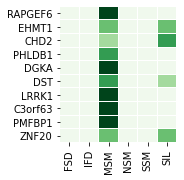

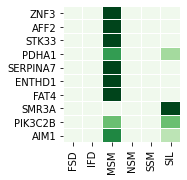

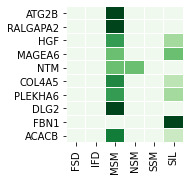

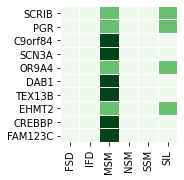

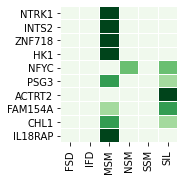

In [78]:
mut_freq_df = mut_freq_df.loc[enrich_df['gene']]
mut_freq_df = mut_freq_df.iloc[:,np.where(mut_freq_df.values.sum(0))[0]]

for i in range(0,n_genes,10):
    fg = plt.figure(figsize=(0.3*mut_freq_df.shape[1],10/4)) 
    sns.heatmap(mut_freq_df.iloc[i:i+10,1:],
                linewidths=0.005,
                yticklabels=True,cbar=False,cmap='Greens',vmin=-0.05,cbar_kws={"shrink": 2})
    plt.xticks(rotation=90,fontsize=10)
    plt.savefig(os.path.join(save_dir,'cBAF.{}.mutation_types.png'.format(i)), dpi=500, bbox_inches = "tight")
    plt.show()

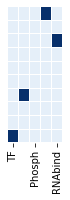

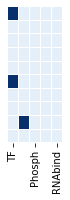

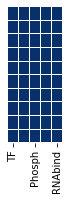

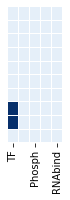

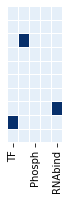

In [48]:
terms2keep = ['transcription factor','kinase activity','phosphatase activity','GTPase binding','RNA binding']

function_mat = np.zeros((enrich_df.shape[0],len(terms2keep)))
for i,g in enumerate(enrich_df['gene'].values):
    if g in gene_function_dict:
        for j,function_term in enumerate(terms2keep):
            for gene_function in gene_function_dict[g]:
                if function_term in gene_function:
                    function_mat[i,j] = 1
    if g in human_tfs:
        function_mat[i,0] = 1

#     else:
#         function_mat[i] = 0.5
# #         print('-',g,'-----',gene_function_dict[g])

function_df = pd.DataFrame(function_mat,index=enrich_df['gene'].values,
                           columns=['TF','Kinase','Phosph','GTPase','RNAbind'])

function_df = function_df.iloc[:,np.where(function_df.values.sum(0))[0]]
for i in range(0,n_genes,10):
    fg = plt.figure(figsize=(1.,10/4)) 
    sns.heatmap(function_df.iloc[i:i+10],cbar=False,cmap='Blues',
                yticklabels=False,linewidths=0.005,vmin=-0.1)

#     plt.savefig(os.path.join(save_dir,'cBAF.{}.function.png'.format(i)), dpi=500, bbox_inches = "tight")
    plt.show()

#### Group by Function

In [79]:
terms2keep = ['transcription factor','kinase activity','phosphatase activity','GTPase binding',
              'RNA binding','methyltransferase']


function_mat = np.zeros((enrich_df.shape[0],len(terms2keep)))
for i,g in enumerate(enrich_df['gene'].values):
    if g in gene_function_dict:
        for j,function_term in enumerate(terms2keep):
            for gene_function in gene_function_dict[g]:
                if function_term in gene_function:
                    function_mat[i,j] = 1
    if g in human_tfs:
        function_mat[i,0] = 1
function_df = pd.DataFrame(function_mat,index=enrich_df['gene'].values, #columns=terms2keep) 
                           columns=['TF','Kinase','Phosph','GTPase','RNAbind','MTase'])
function_df = function_df.iloc[function_df.values.sum(1) > 0]

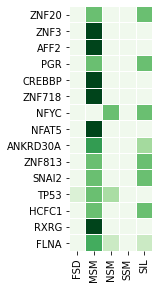

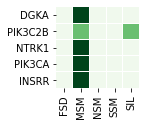

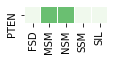

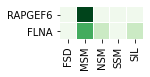

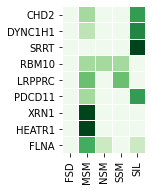

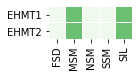

In [82]:
mutation_types = sorted(list(set([v[1] for mut_list in barcode_specific_mutation_dict.values() 
                                  for v in mut_list])))

sorted_genes = sorted(list(set(enrich_df['gene'].values)))
mut_freq_df = pd.DataFrame(np.zeros((len(sorted_genes),len(mutation_types))),
                           index=sorted_genes,columns=mutation_types)

filtered_barcode_set = set([n[:-1] for n in filtered_bulk_adata.obs['barcode'].values])
for barcode,mut_list in barcode_specific_mutation_dict.items():
    if barcode in filtered_barcode_set:
        for gene,mut_type in mut_list:
            if gene in mut_freq_df.index.values:
                mut_freq_df.at[gene,mut_type] = mut_freq_df.loc[gene][mut_type] + 1
            
mut_freq_df = mut_freq_df.div(mut_freq_df.sum(1),axis=0)

mut_freq_df.columns = [' '.join(n.split('_')) for n in mut_freq_df.columns]

mut_types2keep = ['Frame Shift Del', 'In Frame Del', 'In Frame Ins', 
                  'Missense Mutation','Nonsense Mutation', 'Splice Site', 'Silent']
mut_freq_df = mut_freq_df[mut_types2keep]
mut_freq_df.columns = ['FSD','IFD','IFI','MSM','NSM','SSM','SIL']

mut_freq_df = mut_freq_df.loc[function_df.index.values]
mut_freq_df = mut_freq_df.iloc[:,np.where(mut_freq_df.values.sum(0))[0]]

for function in function_df.columns:
    inds = np.where(function_df[function])[0]
    if len(inds):
        fg = plt.figure(figsize=(0.3*mut_freq_df.shape[1],0.3*len(inds))) 
        sns.heatmap(mut_freq_df.iloc[inds],
                    linewidths=0.005,
                    yticklabels=True,cbar=False,cmap='Greens',vmin=-0.05,vmax=1,cbar_kws={"shrink": 2})
        plt.xticks(rotation=90,fontsize=10)
        plt.show()

TF


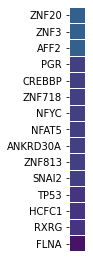

Kinase


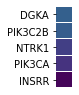

Phosph


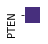

GTPase


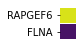

RNAbind


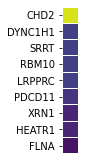

MTase


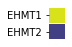

In [83]:
for function in function_df.columns:
    print(function)
    genes = function_df.index.values[np.where(function_df[function])[0]]
    if not os.path.exists(os.path.join(save_dir,'cBAF.{}.enrich_q.png'.format(function))):
        fg = plt.figure(figsize=(0.3,0.3*len(genes))) 
        sns.heatmap(enrich_df[['-log10q']].loc[genes],vmin=1,vmax=2.1,
                    xticklabels=False,cmap='viridis',cbar=False,linewidth=0.005) #,cbar_kws={'shrink': 2})
        plt.show()

#### Background Mutations (all in bulk_adata)

In [39]:
mutation_types = sorted(list(set([v[1] for mut_list in barcode_specific_mutation_dict.values() 
                                  for v in mut_list])))

sorted_genes = sorted(list(set(enrich_df['gene'].values)))
mut_freq_df = pd.DataFrame(np.zeros((len(sorted_genes),len(mutation_types))),
                           index=sorted_genes,columns=mutation_types)

# filtered_barcode_set = set([n[:-1] for n in filtered_bulk_adata.obs['barcode'].values])
for barcode,mut_list in barcode_specific_mutation_dict.items():
    for gene,mut_type in mut_list:
        if gene in mut_freq_df.index.values:
            mut_freq_df.at[gene,mut_type] = mut_freq_df.loc[gene][mut_type] + 1

mut_freq_df = mut_freq_df.div(mut_freq_df.sum(1),axis=0)

mut_freq_df.columns = [' '.join(n.split('_')) for n in mut_freq_df.columns]
mut_freq_df.insert(0,'Gene',mut_freq_df.index.values)

mut_freq_df = mut_freq_df.loc[enrich_df['gene']]
mut_freq_df = mut_freq_df.iloc[:,np.where(mut_freq_df.values.sum(0))[0]]

mut_freq_df.to_csv(os.path.join(save_dir,'cBAF.mutation_types.background.tsv'),index=False,sep='\t')

#### Differential Expression (All Genes)

In [37]:
from scipy.stats import ttest_ind,ranksums
from statsmodels.stats.multitest import fdrcorrection

gene_inds2keep = [i for i,n in enumerate(bulk_adata.var['gene_symbol'].values) if len(n)]
genes2keep = bulk_adata.var['gene_symbol'].values[gene_inds2keep]

de_genes_dict = {}
for (project_id,num_samples) in cbaf_counts:
    
    # BAF-like tumors (w/o BAF mutations)
    sample_bulk_adata = filtered_bulk_adata.copy()[filtered_bulk_adata.obs['project_id'] == project_id]
    sample_inds2keep = np.where(mutation_df.loc[sample_bulk_adata.obs['case_id']].values.sum(1) == 0)[0]
    sample_bulk_adata = sample_bulk_adata[sample_inds2keep]
    
    if sample_bulk_adata.shape[0] >= 2:
        
        # background (no BAF mutations)
        bg_bulk_adata = bulk_adata[bulk_adata.obs['project_id'] == project_id]
        inds2keep = np.where(mutation_df.loc[bg_bulk_adata.obs['case_id']].values.sum(1) == 0)[0]
        bg_bulk_adata = bg_bulk_adata[inds2keep]
        
        print(sample_bulk_adata.shape[0],bg_bulk_adata.shape[0])
        
        # retain genes of interest
        sample_X = sample_bulk_adata.raw.X[:,gene_inds2keep]
        bg_X = bg_bulk_adata.raw.X[:,gene_inds2keep]
        
        t,p = ttest_ind(sample_X,bg_X,equal_var=False,axis=0)
        
        # remove nan genes
        inds2keep = ~np.isnan(p)
        reject,q = fdrcorrection(p[inds2keep])
        
        fc = sample_X[:,inds2keep].mean(0)/bg_X[:,inds2keep].mean(0)
          
        de_genes_dict[project_id] = {g: (fc,q) for g,fc,q in zip(*[genes2keep[inds2keep],fc,q])}

20 109
14 76
11 30
9 231
5 164
4 42
2 82
2 46


In [38]:
thresh = 0.05

up_genes_sets = []
down_genes_sets = []

for project_id,results_dict in de_genes_dict.items():
    
    up_genes_sets.extend([g for g,(fc,q) in results_dict.items() if q < thresh and fc > 1])
    down_genes_sets.extend([g for g,(fc,q) in results_dict.items() if q < thresh and fc < 1])
    
down_genes = Counter(down_genes_sets)
up_genes = Counter(up_genes_sets)


## LISA Results
### cBAF

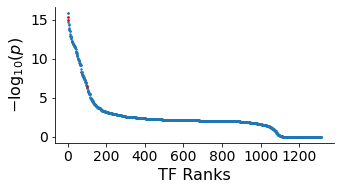

In [96]:
data_dir = './results/cancer/baflike_de_genes'

lisa_df = pd.read_csv(os.path.join(data_dir,'cBAFlike.lisa.csv'))

plt.figure(figsize=(5,2.5))
plt.scatter(np.arange(lisa_df.shape[0]),-np.log10(lisa_df['1st Sample p-value']),s=2)
plt.scatter([2,3,98],[-np.log10(lisa_df['1st Sample p-value'].values[[2,3,98]])],c='red',s=2)
plt.xlabel('TF Ranks',fontsize=16)
plt.ylabel(r'$-\log_{10}(p)$',fontsize=16)

sns.despine(right = True, top = True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [97]:
tf_up_genes = []
for k,v in sorted(up_genes.items(), key=lambda x:x[1],reverse=True):
    if k in lisa_df['Transcription Factor'].values: #.values[0:100]:
        tf_up_genes.append(k)

In [98]:
tf_down_genes = []
for k,v in sorted(down_genes.items(), key=lambda x:x[1],reverse=True):
    if k in lisa_df['Transcription Factor'].values: #.values[0:100]:
        tf_down_genes.append(k)

In [99]:
tf_direction = []
for i,tf in enumerate(lisa_df['Transcription Factor'].values):
    if tf in down_genes and tf not in up_genes:
        tf_direction.append('down')
    elif tf in up_genes and tf not in down_genes:
        tf_direction.append('up')
    elif tf in up_genes and tf in down_genes:
        tf_direction.append('both')
    else:
        tf_direction.append('N/A')

lisa_df['up/down-regulated'] = tf_direction

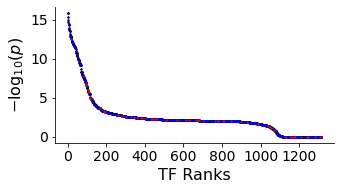

In [103]:
plt.figure(figsize=(5,2.5))
plt.scatter(np.arange(lisa_df.shape[0]),-np.log10(lisa_df['1st Sample p-value']),s=2,c='black')
plt.scatter(np.arange(lisa_df.shape[0])[lisa_tf_down],-np.log10(lisa_df['1st Sample p-value'])[lisa_tf_down],
            s=1,c='blue')
plt.scatter(np.arange(lisa_df.shape[0])[lisa_tf_up],-np.log10(lisa_df['1st Sample p-value'])[lisa_tf_up],
            s=1,c='red')

plt.xlabel('TF Ranks',fontsize=16)
plt.ylabel(r'$-\log_{10}(p)$',fontsize=16)

sns.despine(right = True, top = True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()